In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
try: 
    import emoji
except ImportError:
    !pip install emoji --user
    import emoji
    
#try:
#    from bs4 import BeautifulSoup 
#except:
#    !pip install bs4 --user
#    from bs4 import BeautifulSoup
from tqdm.autonotebook import  tqdm
tqdm.pandas()

try:
    import nltk
    #raise Exception
except:
    !pip install nltk --user
    import nltk
    nltk.download('punkt')
    
#try:
#    import textblob
#except:
#    !pip install textblob --user
#    import textblob
import re

try:
    from polyglot.detect import Detector
except ImportError:
    #!pip install --user pyicu pycld2
    !pip install polyglot --user

    from polyglot.detect import Detector
    
try:
    from googletrans import Translator
except:
    !pip install googletrans --user
    from googletrans import Translator
    

#!pip install -q livelossplot --user
from livelossplot.keras import PlotLossesCallback

/home/dario/.local/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
from flask import Flask, request, render_template
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords

#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')


set(stopwords.words('english'))
app = Flask(__name__)

In [3]:
df = pd.read_pickle("/home/dario/tm-project/data/df_preprocessed_eng_remap.pckle")
df.head(1)

,description,event_id,category,category_label,lang,lang_reliab,desc_stemm,desc_lemm,desc_stemm_no_badwords,desc_lemm_no_badwords,remap_category,remap_category_label
0,"<p><span>Hey explorersssss, what's up?</span><...",239719250,language/ethnic identity,15,English,99,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...,language/ethnic identity,11


In [61]:
import gensim

doc2vec_model = gensim.models.Doc2Vec.load("model_doc2vec")

In [62]:
import keras

from keras.models import load_model

model = load_model("NN_model.h5")
#model.summary()

In [63]:
from gensim.models.doc2vec import TaggedDocument

def vec_for_learning(model, tagged_docs):
    #sents = tagged_docs.values
    #regressors = [model.infer_vector(doc.words, steps=20) for doc in tqdm(tagged_docs.values)]
    #return  regressors
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in tqdm(tagged_docs.values)])
    return targets, regressors


def fake_tagged_doc(desc):
    arr=np.asarray(desc)
    arr=pd.Series(arr)

    test_tagged = arr.apply( lambda r: TaggedDocument(words=str(r).split(" "), tags=["NaN"]))#, axis=1)
    return test_tagged

In [7]:
import emoji

def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])

    return clean_text

def detect_lang(text):
    try:
        lang = Detector(text, quiet=True)
        if lang.reliable:
            return lang.language.name  if lang.language.confidence > 50 else "low_conf"
        else: 
            return "not_reliable"
    except Exception as e: 
        return "error"

In [8]:
europ_languages = ["english", 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 'italian', 'norwegian', 'portuguese', 'russian', 'spanish', 'swedish', 'turkish']
   
stopwords = set(nltk.corpus.stopwords.words(europ_languages))    

#nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

#text = "Another way of achieving this task"
#tokens = word_tokenize(text)
lemmatizer = WordNetLemmatizer()

badwords=[
    "www", "http", "https", "th", "pm", "ticket", "org", "event", "link", "registr", "hi", "oil", "en", "lo", "ca", 
    "month", "monday", "tuesday", "wednesday", "thursday","friday", "saturday", "sunday",
    "meetup","meetups", "meet","area","happen", "event", "group", "regist", "pleas", "please", "join", "rsvp", "member", "mask", 
    "venu", "free", "comment", "thank", "attend", "eventbrit", "mr", "st", "rd", "hour", "mask", "locat", "everyone", "everyon", "contact", "anyone", "great",
    "new", "time", "stand", "host", "check", "line", "com", "fee", "cost", "people", "day", "new", "know", "inform", "email", "bring","welcome", "welcom",
    "boston", "like", "la", "en", "los", "come", "let", "facebook", "available",  "help", "look", "register", "sign","registration",  ]
len(badwords), len(set(badwords)) #woops

(86, 82)

In [16]:
def preproc(raw_text, badwords = badwords, lemmatizer = lemmatizer, stopwords = stopwords, tag_map = tag_map):
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", raw_text)
    text = give_emoji_free_text(text)
    lang = detect_lang(text)
    
    
    if lang != "English":
        langs=Detector(text).languages
        lang=langs[0].name.lower()        
        translator= Translator()#from_lang=langs[0].code, to_lang="en")
        text = translator.translate(text).text
    
    text = text.replace("'s ", " ")
    text = re.sub("[^a-zA-Z]", " ", text).lower().split( ) #.replace("|","").replace("!","").replace("?","")
    text = [token for token in text if all([token not in stopwords, token not in badwords])] 
    text = [lemmatizer.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(text)]
    text = [elem for elem in text if elem not in badwords] #badwords after stemming
    return (" ".join(text))

In [21]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
category_remap_dict = {
    "LGBT": "socializing",
    "singles": "socializing",
    "fashion/beauty": "health/wellbeing",
    "movies/film": "socializing",
    "book clubs": "education/learning",
    "sci-fi/fantasy": "games",
    "support": "health/wellbeing",
    "cars/motorcycles": "outdoors/adventure"
}

df["remap_category_2"] = df.category.map(lambda x: category_remap_dict[x] if x in category_remap_dict.keys() else x )

lb = LabelEncoder().fit(df.remap_category_2)

In [25]:
clean_test=preproc(test_text_2)
tag_doc=fake_tagged_doc(clean_test)
desc_vec=vec_for_learning(doc2vec_model, tag_doc)
predicted_category=model.predict_classes(np.array(desc_vec))

lb.inverse_transform(predicted_category)

array(['career/business'], dtype=object)

In [64]:
tagged = df.progress_apply(lambda r: gensim.models.doc2vec.TaggedDocument(words=str(r.desc_lemm_no_badwords).split(" "), tags=[r.remap_category]), axis=1)

In [73]:
y, X = vec_for_learning(doc2vec_model, tagged)


In [70]:
train_vect = np.asarray(X)
y_ar = np.asarray(y)

In [79]:
lb = LabelEncoder().fit(df.remap_category_2)
y_tr = lb.transform(y_ar)
y_cat_new = to_categorical(y_tr, num_classes = 24)


In [74]:
train_vect_max = np.load("d2v_lemm_no_badwords.npz")['X']
y_max = np.load("d2v_lemm_no_badwords.npz")['y']

In [76]:
y_tr = lb.transform(y_max)
y_cat = to_categorical(y_tr, num_classes = 24)


In [88]:
from keras.models import clone_model
from keras.optimizers import Nadam
model_new = clone_model(model)
lr = 0.00015
optimizer = Nadam(lr = lr)
loss = 'categorical_crossentropy'
metrics = ['acc']
model_new.compile(optimizer = Nadam(lr = lr), loss = loss, metrics = metrics)

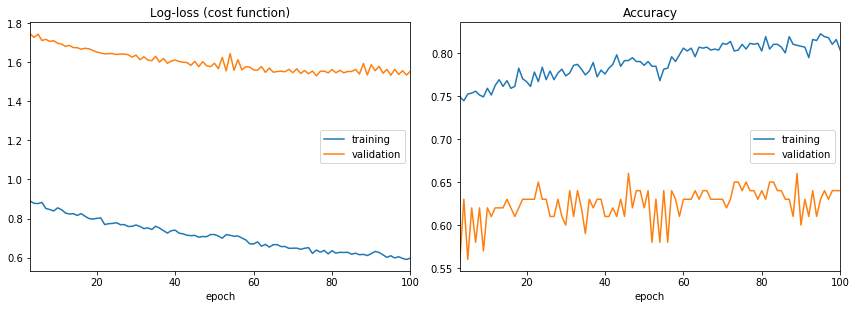

Log-loss (cost function):
training   (min:    0.590, max:    0.889, cur:    0.598)
validation (min:    1.530, max:    1.745, cur:    1.554)

Accuracy:
training   (min:    0.744, max:    0.822, cur:    0.803)
validation (min:    0.560, max:    0.660, cur:    0.640)


In [90]:
model_new.fit(train_vect, y_cat_new, 
              batch_size = 2048,
              epochs = 100,
              validation_split = .1,
              verbose = 0,
              callbacks = [PlotLossesCallback()])

In [91]:
model_new.save("model_new.h5")

In [77]:
model.evaluate(train_vect_max, y_cat)

120809/120809 [==============================] - 11s 93us/step


[0.5354822255963784, 0.8271817564964294]

In [13]:
@app.route('/')
def my_form():
    return render_template('form.html')

@app.route('/', methods=['POST'])
def my_form_post(preproc = preproc):
    text1 = request.form['text1'].lower()

    clean_test=preproc(text1)
    tag_doc=fake_tagged_doc(clean_test)
    desc_vec=vec_for_learning(doc2vec_model, tag_doc)
    predicted_category=model.predict_classes(np.array(desc_vec))
    
    return render_template('form.html', final="yolo", text1=text1, category = lb.inverse_transform(predicted_category))

if __name__ == "__main__":
    app.run(debug=True, host="127.0.0.1", port=5002, threaded=True)

AssertionError: View function mapping is overwriting an existing endpoint function: my_form

In [ ]:
%tb